## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l1, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drop_ratio=0.5, l1_ratio=1e-4):

    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
            x = BatchNormalization()(x)
            x = Dropout(drop_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(x)
            x = BatchNormalization()(x)
            x = Dropout(drop_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATES = [0.1, 0.01]
EPOCHS = 25
BATCH_SIZE = 128

In [7]:
results = {}
for LEARNING_RATE in LEARNING_RATES:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]


    results['LEARNING_RATE_'+str(LEARNING_RATE)] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
__________

50000/50000 [==============================] - 6s 123us/step - loss: 4.1530 - acc: 0.2709 - val_loss: 4.3170 - val_acc: 0.1570
Epoch 9/25
50000/50000 [==============================] - 6s 122us/step - loss: 4.0383 - acc: 0.2769 - val_loss: 4.2212 - val_acc: 0.1805
Epoch 10/25
50000/50000 [==============================] - 6s 122us/step - loss: 4.0561 - acc: 0.2723 - val_loss: 3.9832 - val_acc: 0.2257
Epoch 11/25
50000/50000 [==============================] - 6s 122us/step - loss: 4.0488 - acc: 0.2726 - val_loss: 4.6932 - val_acc: 0.1296
Epoch 12/25
50000/50000 [==============================] - 6s 124us/step - loss: 3.9581 - acc: 0.2739 - val_loss: 4.1414 - val_acc: 0.2151
Epoch 13/25
50000/50000 [==============================] - 6s 124us/step - loss: 3.8972 - acc: 0.2742 - val_loss: 4.0376 - val_acc: 0.2587
Epoch 14/25
50000/50000 [==============================] - 6s 126us/step - loss: 3.8097 - acc: 0.2733 - val_loss: 4.0129 - val_acc: 0.2031
Epoch 15/25
50000/50000 [===============

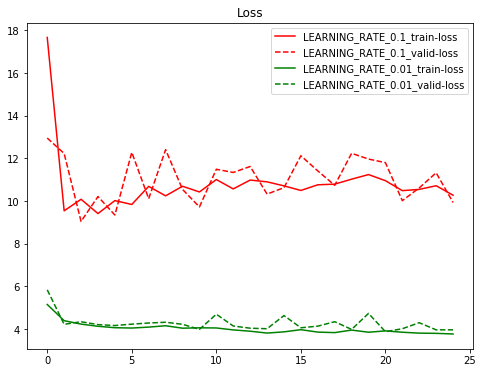

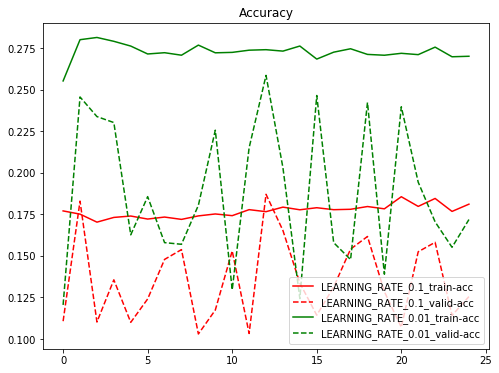

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond+'_train-loss', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond+'_valid-loss', color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond+'_train-acc', color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond+'_valid-acc', color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()